## Computer Vision Systems - Medical Images - Binary Classification Problem

In [7]:
import os, shutil
import cv2
import random
import matplotlib.pylab as plt
from glob import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline


### Prepare File Directories and Image Paths and Load Labels

In [8]:

# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/Users/alicevnix/Desktop/images'

# The directory where we will
# store our smaller dataset
base_dir = '/Users/alicevnix/Desktop/final_project'
shutil.rmtree(base_dir)
os.mkdir(base_dir)

images = glob(os.path.join(original_dataset_dir, "*.png"))
    

# read in the sample labels as a csv file
labels = pd.read_csv('/Users/alicevnix/Desktop/sample_labels.csv')   

In [9]:
# Creating appropriate directories for training, validation, test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)


In [10]:
print('total original xray images:', len(os.listdir(original_dataset_dir)))


total original xray images: 5608


In [11]:
images[0:5]


['/Users/alicevnix/Desktop/images/00000013_005.png',
 '/Users/alicevnix/Desktop/images/00000013_026.png',
 '/Users/alicevnix/Desktop/images/00000017_001.png',
 '/Users/alicevnix/Desktop/images/00000030_001.png',
 '/Users/alicevnix/Desktop/images/00000032_001.png']

### Show Three Random Xray Images

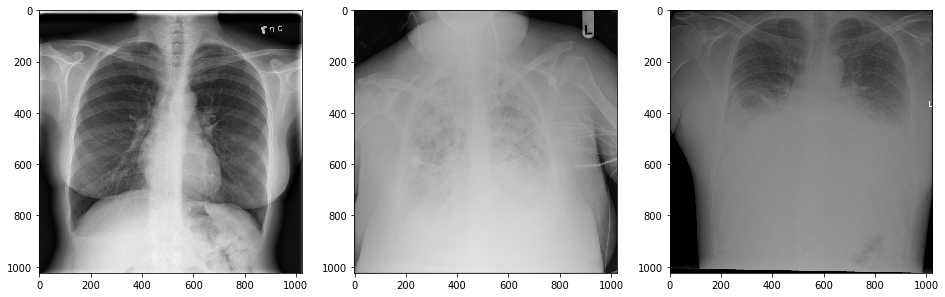

In [12]:
r = random.sample(images, 3)
r

# Matplotlib black magic
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(cv2.imread(r[0]))

plt.subplot(132)
plt.imshow(cv2.imread(r[1]))

plt.subplot(133)
plt.imshow(cv2.imread(r[2]));    


### Examine the Labels 

In [13]:
labels.head(10)


Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   
5  00000040_003.png                                 Consolidation|Mass   
6  00000042_002.png                                         No Finding   
7  00000057_001.png                                         No Finding   
8  00000061_002.png                                           Effusion   
9  00000061_019.png                                         No Finding   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   
5            3          40        068Y              M            PA   
6            2          42        071Y              M            AP   
7            1          57        071Y              M            AP   
8            2          61        077Y              M            PA   
9           19          61        077Y              M            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                3056                 2544                        0.139   
1                2500                 2048                        0.168   
2                2500                 2048                        0.168   
3                2992                 2991                        0.143   
4                2500                 2048                        0.168   
5                2500                 2048                        0.168   
6                3056                 2544                        0.139   
7                3056                 2544                        0.139   
8                2992                 2991                        0.143   
9                3056                 2544                        0.139   

   OriginalImagePixelSpacing_y  
0                        0.139  
1                        0.168  
2                        0.168  
3                        0.143  
4                        0.168  
5                        0.168  
6                        0.139  
7                        0.139  
8                        0.143  
9                        0.139

In [14]:
len(labels)


5606

In [15]:
labels.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y'],
      dtype='object')

In [16]:
# Count for each disease category for the feature 'Finding Labels'
# Imbalance of classes will need appropriate weights later

labels['Finding Labels'].value_counts()


No Finding                                                           3044
Infiltration                                                          503
Effusion                                                              203
Atelectasis                                                           192
Nodule                                                                144
Pneumothorax                                                          114
Mass                                                                   99
Consolidation                                                          72
Effusion|Infiltration                                                  69
Pleural_Thickening                                                     65
Atelectasis|Infiltration                                               57
Atelectasis|Effusion                                                   55
Cardiomegaly                                                           50
Infiltration|Nodule                   

In [15]:
labels.dtypes

Image Index                     object
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                     object
Patient Gender                  object
View Position                   object
OriginalImageWidth               int64
OriginalImageHeight              int64
OriginalImagePixelSpacing_x    float64
OriginalImagePixelSpacing_y    float64
dtype: object

In [17]:
# Checking for missing values 

print(labels.isnull().sum())


Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImageWidth             0
OriginalImageHeight            0
OriginalImagePixelSpacing_x    0
OriginalImagePixelSpacing_y    0
dtype: int64


### Data Preprocessing

Data should be formatted into appropriately preprocessed tensors.  Images with Nodules will be labeled "Nodule" and images without will be labeled "Not_nodule".  During this process I am creating two arrays - one for the images and one for the labels.  We then can resize the images from (1024 x 1024) to (128 x 128) pixels.

*Note - For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue. For a black-and-white picture, like the Xray images, the depth is 1 (levels of gray) (Chollet, 2015).

Currently, the data sits on a drive as png files, so the steps for getting it into the network are roughly as follows:
1 Read the picture files.
2 Decode the png content to RGB grids of pixels.
3 Convert these into floating-point tensors.
4 Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know,
neural networks prefer to deal with small input values) (Chollet, 2015).

In [18]:
# Function to separate the data based on which x-rays show Lung Nodules and which x-rays do not. 

def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    
    disease="Nodule"

    x = [] # images as arrays
    y = [] # labels Nodule or Not_nodule
    HEIGHT = 128
    WIDTH = 128

    for img in images:
        base = os.path.basename(img)
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]

        # Read and resize image
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))

        # Labels
        if disease in finding:
            #finding = str(disease)
            finding = 1
            y.append(finding)

        else:
            #finding = "Not_" + str(disease)
            finding = 0
            y.append(finding)

    return x,y


In [19]:
x,y = proc_images()


In [20]:
# Set it up as a dataframe

df = pd.DataFrame()
df["labels"]=y
df["images"]=x


In [21]:
# Below we have 5,606 images with 3D tensor of Height, Width, Channels = (128,128,3)

print(len(df), df.images[0].shape)


5606 (128, 128, 3)


In [12]:
# Shape of x or image

print(np.array(x).shape)


(5606, 128, 128, 3)


### Fundamentals of Convolutional Neural Networks

CNNs are defined by two key parameters:
1. Size of the patches extracted from the inputs, typically either 3 x 3 or 5 x 5
2. Depth of the output feature map - number of filters computed by the convolution.  It will end with a larger depth. (Chollet, 2015).

A convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an output feature map. This output feature map is still a 3D tensor: it has a width and a height. Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for filters. Filters encode specific aspects of the input data (Chollet, 2015).

In Keras, Conv2D layers, specify parameters and the first arguments passed to the layer:

Conv2D(output_depth, (window_height, window_width)).

A convolution works by sliding these windows of size 3 × 3 or 5 × 5 over the 3D input feature map, stopping at every possible location, and extracting the 3D patch of sur- rounding features (shape (window_height, window_width, input_depth)). Each such 3D patch is then transformed (via a tensor product with the same learned weight matrix, called the convolution kernel ) into a 1D vector of shape (output_depth,). All of these vectors are then spatially reassembled into a 3D output map of shape (height, width, output_depth) (Chollet, 2015).

Architecture for convnets will use the following structure: the convnet will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers.  Lastly, you will get to a flatten layer.  A common pattern to see will be the depth of the feature maps progressively increases in the network whereas the size of the feature maps decreases.  Activations will be set to 'relu' while loss will be binary_crossentropy, and optimization will be RMSprop.  Sigmoid activation will be the last - this unit will encode the probability that the network is looking at one class versus the other (Chollet, 2015).

Maxpooling - alternates between Conv2D:  You will notice that the size of the feature maps is halved after every MaxPooling2D layer.  That is the role of max pooling: to aggressively downsample feature maps, much like strided convolutions.  Could also use average pooling instead as a downsampling method for input patches (Chollet, 2015).

### Test, Train, Split (80/10/10)

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split

In [23]:
# Step one: Split the data in two sets, 80% for training, 20% for val/test

X_train, X_valtest, y_train, y_valtest = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

# Step two: Split the 20% into validation and test sets

X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1, stratify=y_valtest)

In [24]:
# Look at the dimensions of each set of images

print(np.array(X_train).shape)
print(np.array(X_val).shape)
print(np.array(X_test).shape)


(4484, 128, 128, 3)
(561, 128, 128, 3)
(561, 128, 128, 3)


In [29]:
# Saving arrays

np.savez("x_images_arrays", x)
np.savez("y_nodule_labels", y)


In [30]:
# ls means 'list show' to confirm

!ls -1


AnacondaProjects
Applications
CITI_BIKE.ipynb
DAT-NYC-11.14.17
Deep_Learning_Digits_Example.ipynb
Desktop
Documents
Downloads
Final_Project.ipynb
GitHub
ISLR
Library
Machine_Learning_Project_Sklearn_1.ipynb
Machine_Learning_Project_Sklearn_2.ipynb
Machine_Learning_Project_Sklearn_3.ipynb
Machine_Learning_Project_Sklearn_4.ipynb
Missing_Values_Example.ipynb
Movies
Music
NGAP.xlsx
Ozone_Data.ipynb
Pictures
Practicum_Project
Public
Python_Fun
Rprof.out
TEMPmodel.txt
anaconda3
cats_and_dogs_small_1.h5
dat-2017-11-14
data
data.R
my-hw-repo
opencv-source
scikit_learn_data
seaborn-data
test-output
x_images_arrays.npz
y.R
y_infiltration_labels.npz
y_nodule_labels.npz
ytb.uid


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split

In [34]:
# Load npz file containing image arrays
x_npz = np.load("x_images_arrays.npz")
x = x_npz['arr_0']
# Load binary encoded labels for Lung Nodules: 0=Not_nodule 1=Nodule
y_npz = np.load("y_nodule_labels.npz")
y = y_npz['arr_0']


### Let's Build a Model from Scratch

In [36]:
# Instantiate a small convnet for nodule vs. no nodule
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(112, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(112, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [37]:
# Dimensions of the feature maps
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 112)       64624     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 112)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 112)       113008    
__________

In [38]:
# Compilation step
from keras import optimizers
model.compile(loss='binary_crossentropy',
        optimizer=optimizers.RMSprop(lr=1e-4),
        metrics=['acc'])


In [53]:
# Defining number of mini-batches and epochs (each interation over all of the training data) 
epochs = 30
batch_size = 20


In [54]:
# Use DataImageGenerator to further preprocess images
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
valtest_datagen = ImageDataGenerator(rescale=1./255)


In [58]:
# Using ImageDataGenerator to read images 
train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size= batch_size)
validation_generator = valtest_datagen.flow(np.array(X_val), y_val, batch_size= batch_size)



In [60]:
# Look at the output of generators

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    

data batch shape: (20, 128, 128, 3)
labels batch shape: (20,)


In [61]:
# Fitting the model using a batch generator

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)


Epoch 1/30
100/100 [==============================] - 105s - loss: 0.2377 - acc: 0.9455 - val_loss: 0.2276 - val_acc: 0.9429
Epoch 2/30
100/100 [==============================] - 100s - loss: 0.2261 - acc: 0.9435 - val_loss: 0.2286 - val_acc: 0.9439
Epoch 3/30
100/100 [==============================] - 97s - loss: 0.2105 - acc: 0.9500 - val_loss: 0.2324 - val_acc: 0.9419
Epoch 4/30
100/100 [==============================] - 97s - loss: 0.2419 - acc: 0.9385 - val_loss: 0.2260 - val_acc: 0.9439
Epoch 5/30
100/100 [==============================] - 96s - loss: 0.2258 - acc: 0.9445 - val_loss: 0.2468 - val_acc: 0.9397
Epoch 6/30
100/100 [==============================] - 98s - loss: 0.2366 - acc: 0.9400 - val_loss: 0.2241 - val_acc: 0.9439
Epoch 7/30
100/100 [==============================] - 97s - loss: 0.2132 - acc: 0.9490 - val_loss: 0.2362 - val_acc: 0.9397
Epoch 8/30
100/100 [==============================] - 97s - loss: 0.2240 - acc: 0.9430 - val_loss: 0.2413 - val_acc: 0.9376
Epoch 

### Regularization with Augmentation

Data augmentation is a great way to fight overfitting; therefore, data augmentation is a regularization technique.  It basically takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images.  During the training period it helps to expose the model to more aspects of the data and thus, generalize better.  This can be accomplished using Keras ImageDataGenerator (Chollet, 2015).

### Dropout or LayerNorm